Hier möchte einen Solver schreiben, der einen Verformungsfall einer  ebenen Platte betrachtet. 
Hierbei orientiere ich mich an dem folgenden Tutorial:
https://www.youtube.com/watch?v=1j_HdsVkglk&list=PLDatYNwS3wZ_b9xVZOb2K9zUTDOp0geta0T

In [9]:
import sys
import numpy as np
import math
from matplotlib import pyplot as plt

In [10]:
def shape(xi):
    """
    Berechnet die Formfunktionen für ein quadratisches Element an den gegebenen natürlichen Koordinaten.

    Args:
        xi (tuple): Ein Tupel der natürlichen Koordinaten (xi, eta).

    Returns:
        numpeta.ndarray: Ein Array der Formfunktionen an den gegebenen natürlichen Koordinaten.
    """
    xi, eta = tuple(xi)
    N = [
        (1.0-xi)*(1.0-eta),
        (1.0+xi)*(1.0-eta), 
        (1.0+xi)*(1.0+eta), 
        (1.0-xi)*(1.0+eta)
        ]
    return 0.25*np.array(N)

In [11]:
def gradshape(xi):
    """
    Computes the gradient of the shape functions for a quadrilateral element.

    Parameters:
    xi (tuple): A tuple containing the local coordinates (xi, eta) where xi and eta are 
                the local coordinates in the reference element.

    Returns:
    numpy.ndarray: A 2x4 array containing the gradients of the shape functions with respect 
                   to the local coordinates (xi, eta). The first row contains the derivatives 
                   with respect to xi, and the second row contains the derivatives with respect 
                   to eta.

    The shape functions are defined as follows:
    N1 = 0.25 * (1 - xi) * (1 - eta)
    N2 = 0.25 * (1 + xi) * (1 - eta)
    N3 = 0.25 * (1 + xi) * (1 + eta)
    N4 = 0.25 * (1 - xi) * (1 + eta)

    The gradients of the shape functions are computed as:
    dN/dxi  = [ -(1 - eta), (1 - eta),  (1 + eta), -(1 + eta)]
    dN/deta = [ -(1 - xi), -(1 + xi),  (1 + xi),  (1 - xi)]
    """
    xi ,eta = tuple(xi)
    dN = [
        [ -(1.0-eta), (1.0-eta) ,  (1.0+eta) ,-(1.0+eta)],
        [ -(1.0-xi) ,-(1.0+xi)  ,  (1.0+xi)  , (1.0-xi) ]
    ]
    return 0.25*np.array(dN)

In [12]:
def local_error(str):
    print("*** Error ***")
    print(str)
    sys.exit()

In [13]:
def read_inp_file(inpFileName, nodes, conn, boundary):
	print('\n** Read input file')
	inpFile = open(inpFileName, 'r')
	lines = inpFile.readlines()
	inpFile.close()
	state = 0
	for line in lines:
		line = line.strip()
		if len(line) <= 0: continue
		if line[0] == '*':
			state = 0
		if line.lower() == "*node":
			state = 1
			continue
		if line.lower() == "*element":
			state = 2
			continue
		if line.lower() == "*boundary":
			state = 3
			continue
		if state == 0:
			continue
		if state == 1:
			# read nodes
			values = line.split(",")
			if len(values) != 3:
				local_error("A node definition needs 3 values")
			nodeNr = int(values[0]) - 1  # zero indexed
			xx = float(values[1])
			yy = float(values[2])
			nodes.append([xx,yy])   # assume the nodes are ordered 1, 2, 3...
			continue
		if state == 2:
			# read elements
			values = line.split(",")
			if len(values) != 5:
				local_error("An element definition needs 5 values")
			elemNr = int(values[0])
			n1 = int(values[1]) - 1  # zero indexed
			n2 = int(values[2]) - 1
			n3 = int(values[3]) - 1
			n4 = int(values[4]) - 1
			#conn.append([n1, n2, n3, n4]) # assume elements ordered 1, 2, 3
			conn.append([n1, n4, n3, n2]) # assume elements ordered 1, 2, 3
			continue
		if state == 3:
			# read displacement boundary conditions
			values = line.split(",")
			if len(values) != 4:
				local_error("A displacement boundary condition needs 4 values")
			nodeNr = int(values[0]) - 1  # zero indexed
			dof1 = int(values[1])
			dof2 = int(values[2])
			val = float(values[3])
			if dof1 == 1:
				boundary.append([nodeNr,1,val])
			if dof2 == 2:
				boundary.append([nodeNr,2,val])
			continue

In [14]:
def run():
	##
	## Main Program
	##
	nodes = []
	conn = []
	boundary = []
	if len(sys.argv) <= 1:
		local_error('No input file provided.')
	print('Input file:', sys.argv[1])
	file_name = r"C:\Users\lars-\OneDrive\Dokumente\GitHub\FEM\Dogbone_tension.input"
	read_inp_file(file_name, nodes, conn, boundary)
	nodes = np.array(nodes)
	num_nodes = len(nodes)
	print('   number of nodes:', len(nodes))
	print('   number of elements:', len(conn))
	print('   number of displacement boundary conditions:', len(boundary))

	###############################
	# Plane-strain material tangent (see Bathe p. 194)
	# C is 3x3
	E = 100.0
	v = 0.3
	C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])
	###############################
	# Make stiffness matrix
	# if N is the number of DOF, then K is NxN
	K = np.zeros((2*num_nodes, 2*num_nodes))    # square zero matrix
	# 2x2 Gauss Quadrature (4 Gauss points)
	# q4 is 4x2
	q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)
	print('\n** Assemble stiffness matrix')
	# strain in an element: [strain] = B    U
	#                        3x1     = 3x8  8x1
	#
	# strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
	#          = B11 u1          + B13 u1          + B15 u1          + B17 u1
	#          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
	B = np.zeros((3,8))
	# conn[0] is node numbers of the element
	for c in conn:     # loop through each element
		# coordinates of each node in the element
		# shape = 4x2
		# for example:
		#    nodePts = [[0.0,   0.0],
		#               [0.033, 0.0],
		#               [0.033, 0.066],
		#               [0.0,   0.066]]
		nodePts = nodes[c,:]
		Ke = np.zeros((8,8))	# element stiffness matrix is 8x8
		for q in q4:			# for each Gauss point
			# q is 1x2, N(xi,eta)
			dN = gradshape(q)       # partial derivative of N wrt (xi,eta): 2x4
			J  = np.dot(dN, nodePts).T # J is 2x2
			dN = np.dot(np.linalg.inv(J), dN)    # partial derivative of N wrt (x,y): 2x4
			# assemble B matrix  [3x8]
			B[0,0::2] = dN[0,:]
			B[1,1::2] = dN[1,:]
			B[2,0::2] = dN[1,:]
			B[2,1::2] = dN[0,:]
			# element stiffness matrix
			Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
		# Scatter operation
		for i,I in enumerate(c):
			for j,J in enumerate(c):
				K[2*I,2*J]     += Ke[2*i,2*j]
				K[2*I+1,2*J]   += Ke[2*i+1,2*j]
				K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
				K[2*I,2*J+1]   += Ke[2*i,2*j+1]
	###############################
	# Assign nodal forces and boundary conditions
	#    if N is the number of nodes, then f is 2xN
	f = np.zeros((2*num_nodes))          # initialize to 0 forces
	# How about displacement boundary conditions:
	#    [k11 k12 k13] [u1] = [f1]
	#    [k21 k22 k23] [u2]   [f2]
	#    [k31 k32 k33] [u3]   [f3]
	#
	#    if u3=x then
	#       [k11 k12 k13] [u1] = [f1]
	#       [k21 k22 k23] [u2]   [f2]
	#       [k31 k32 k33] [ x]   [f3]
	#   =>
	#       [k11 k12 k13] [u1] = [f1]
	#       [k21 k22 k23] [u2]   [f2]
	#       [  0   0   1] [u3]   [ x]
	#   the reaction force is
	#       f3 = [k31 k32 k33] * [u1 u2 u3]
	for i in range(len(boundary)):  # apply all boundary displacements
		nn  = boundary[i][0]
		dof = boundary[i][1]
		val = boundary[i][2]
		j = 2*nn
		if dof == 2: j = j + 1
		K[j,:] = 0.0
		K[j,j] = 1.0
		f[j] = val
	###############################
	print('\n** Solve linear system: Ku = f')	# [K] = 2N x 2N, [f] = 2N x 1, [u] = 2N x 1
	u = np.linalg.solve(K, f)
	###############################
	print('\n** Post process the data')
	# (pre-allocate space for nodal stress and strain)
	node_strain = []
	node_stress = []
	for ni in range(len(nodes)):
		node_strain.append([0.0, 0.0, 0.0])
		node_stress.append([0.0, 0.0, 0.0])
	node_strain = np.array(node_strain)
	node_stress = np.array(node_stress)

	print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
	print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')
	emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
	emax = np.array([-9.0e9, -9.0e9, -9.0e9])
	smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
	smax = np.array([-9.0e9, -9.0e9, -9.0e9])
	for c in conn:	# for each element (conn is Nx4)
										# c is like [2,5,22,53]
		nodePts = nodes[c,:]			# 4x2, eg: [[1.1,0.2], [1.2,0.3], [1.3,0.4], [1.4, 0.5]]
		for q in q4:					# for each integration pt, eg: [-0.7,-0.7]
			dN = gradshape(q)					# 2x4
			J  = np.dot(dN, nodePts).T			# 2x2
			dN = np.dot(np.linalg.inv(J), dN)	# 2x4
			B[0,0::2] = dN[0,:]					# 3x8
			B[1,1::2] = dN[1,:]
			B[2,0::2] = dN[1,:]
			B[2,1::2] = dN[0,:]

			UU = np.zeros((8,1))				# 8x1
			UU[0] = u[2*c[0]]
			UU[1] = u[2*c[0] + 1]
			UU[2] = u[2*c[1]]
			UU[3] = u[2*c[1] + 1]
			UU[4] = u[2*c[2]]
			UU[5] = u[2*c[2] + 1]
			UU[6] = u[2*c[3]]
			UU[7] = u[2*c[3] + 1]
			# get the strain and stress at the integration point
			strain = B @ UU		# (B is 3x8) (UU is 8x1) 		=> (strain is 3x1)
			stress = C @ strain	# (C is 3x3) (strain is 3x1) 	=> (stress is 3x1)
			emin[0] = min(emin[0], strain[0][0])
			emin[1] = min(emin[1], strain[1][0])
			emin[2] = min(emin[2], strain[2][0])
			emax[0] = max(emax[0], strain[0][0])
			emax[1] = max(emax[1], strain[1][0])
			emax[2] = max(emax[2], strain[2][0])

			node_strain[c[0]][:] = strain.T[0]
			node_strain[c[1]][:] = strain.T[0]
			node_strain[c[2]][:] = strain.T[0]
			node_strain[c[3]][:] = strain.T[0]
			node_stress[c[0]][:] = stress.T[0]
			node_stress[c[1]][:] = stress.T[0]
			node_stress[c[2]][:] = stress.T[0]
			node_stress[c[3]][:] = stress.T[0]
			smax[0] = max(smax[0], stress[0][0])
			smax[1] = max(smax[1], stress[1][0])
			smax[2] = max(smax[2], stress[2][0])
			smin[0] = min(smin[0], stress[0][0])
			smin[1] = min(smin[1], stress[1][0])
			smin[2] = min(smin[2], stress[2][0])
	print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
	print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
	print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
	print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')
	###############################
	print('\n** Plot displacement')
	xvec = []
	yvec = []
	res  = []
	plot_type = 'e11'
	for ni,pt in enumerate(nodes):
		xvec.append(pt[0] + u[2*ni])
		yvec.append(pt[1] + u[2*ni+1])
		if plot_type=='u1':  res.append(u[2*ni])				# x-disp
		if plot_type=='u2':  res.append(u[2*ni+1])				# y-disp
		if plot_type=='s11': res.append(node_stress[ni][0])		# s11
		if plot_type=='s22': res.append(node_stress[ni][1])		# s22
		if plot_type=='s12': res.append(node_stress[ni][2])		# s12
		if plot_type=='e11': res.append(node_strain[ni][0])		# e11
		if plot_type=='e22': res.append(node_strain[ni][1])		# e22
		if plot_type=='e12': res.append(node_strain[ni][2])		# e12
	tri = []
	for c in conn:
		tri.append( [c[0], c[1], c[2]] )
		tri.append( [c[0], c[2], c[3]] )
	t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
	#plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
	plt.grid()
	plt.colorbar(t)
	plt.title(plot_type)
	plt.axis('equal')
	plt.show()
	print('Done.')

Input file: --f=c:\Users\lars-\AppData\Roaming\jupyter\runtime\kernel-v33b7a0fe1b0bdcd32f48f4d1f4b0ffdd9688743a7.json

** Read input file
   number of nodes: 1428
   number of elements: 1298
   number of displacement boundary conditions: 48

** Assemble stiffness matrix

** Solve linear system: Ku = f

** Post process the data
   min displacements: u1=-1.762e-16, u2=-0.02621
   max displacements: u1=1, u2=0.02621
   min strains: e11=0.003018, e22=-0.006452, e12=-0.007158
   max strains: e11=0.01491, e22=-6.645e-05, e12=0.006862
   min stress:  s11=0.3236, s22=-0.05426, s12=-0.2753
   max stress:  s11=1.649, s22=0.2906, s12=0.2639

** Plot displacement


C:\Users\lars-\AppData\Local\Temp\ipykernel_65468\3988098650.py:188: UserWarning: The following kwargs were not used by contour: 'triangles'
  t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)


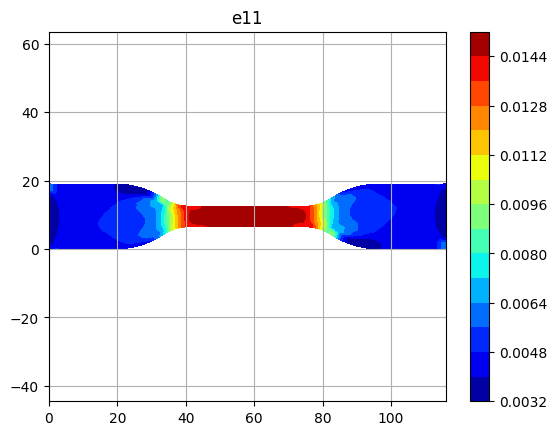

Done.


: 

In [16]:
run()